# Drifter data cleaning: benchmarking performance with synthetic drifter trajectories

We generate synthetic velocity timeseries with low and high frequency components, data gaps.
Data is then interpolated on a regular timeline (with a smoothness constraint).



In [2]:
import xarray as xr
import pandas as pd
import numpy as np

import hvplot.xarray
import hvplot.pandas

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

import pynsitu as pyn

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


---

## generate synthetic timeseries

We sum a low frequency signal, a (polarized) near-inertial component and (non-polarized) semi-diurnal and diurnal tidal signals


In [3]:
# timeline: 100 days with hourly sampling
dt = 1 / 24
t = (100, dt)
# number of random draws
N = 10

# use a common decorrelation timescale, no rationale
# T = [5,10,20,40]
T = 10

# velocity amplitudes
U_low = 0.3
U_ni = 0.2
U_2 = 0.05
U_1 = 0.02

In [4]:
## low frequency signal: a la Viggiano

tau_eta = 0.1  # short timescale
n_layers = 5  # number of layers
u_low = (
    ts.spectral_viggiano(t, T, tau_eta, n_layers, draws=N, seed=0)
    .compute()
    .rename("u_low")
    * U_low
)
v_low = (
    ts.spectral_viggiano(t, T, tau_eta, n_layers, draws=N, seed=1)
    .compute()
    .rename("v_low")
    * U_low
)

In [5]:
## near-inertial signal: Sykulski et al. 2016

f = pyn.geo.coriolis(45) * 86400
E_ni = lambda omega: 1 / ((omega - f) ** 2 + T**-2)

uv_ni = ts.spectral(t, spectrum=E_ni, draws=N).compute() * U_ni
u_ni = np.real(uv_ni).rename("u_ni")
v_ni = np.imag(uv_ni).rename("v_ni")

In [6]:
u_high = sg.high_frequency_signal()
u_high.analytical_spectrum

T*U**2*(T**2*(omega**2 + sigma**2) + 1)/(T**4*(-omega**2 + sigma**2)**2 + 2*T**2*(omega**2 + sigma**2) + 1)

In [6]:
## tidal signals

# see high frequency spectrum
# u_high = sg.high_frequency_signal()
# u_high.analytical_spectrum

# semi-diurnal
omega0 = 2 * np.pi * 2  # semi-diurnal
E_2 = lambda omega: (omega**2 + omega0**2 + T**-2) / (
    (omega**2 - omega0**2) ** 2 + T**-2 * (omega**2 + omega0**2) + T**-4
)

uv_2 = ts.spectral(t, spectrum=E_2, draws=N).compute() * U_2
u_2 = np.real(uv_2).rename("u_2")
v_2 = np.imag(uv_2).rename("v_2")

# diurnal
omega0 = 2 * np.pi  # semi-diurnal
E_1 = lambda omega: (omega**2 + omega0**2 + T**-2) / (
    (omega**2 - omega0**2) ** 2 + T**-2 * (omega**2 + omega0**2) + T**-4
)

uv_1 = ts.spectral(t, spectrum=E_1, draws=N).compute() * U_1
u_1 = np.real(uv_1).rename("u_1")
v_1 = np.imag(uv_1).rename("v_1")

In [7]:
# combine all time series

ds = xr.merge([u_low, v_low, u_ni, v_ni, u_2, v_2, u_1, v_1])

ds["u"] = (ds["u_low"] + ds["u_ni"] + ds["u_2"] + ds["u_1"]).assign_attrs(units="m/s")
ds["v"] = (ds["v_low"] + ds["v_ni"] + ds["v_2"] + ds["v_1"]).assign_attrs(units="m/s")

ds["time"] = ds["time"].assign_attrs(units="days")
ds["x"] = ds["u"].cumulative_integrate("time").assign_attrs(units="m") * 86400
ds["y"] = ds["v"].cumulative_integrate("time").assign_attrs(units="m") * 86400
ds["ax"] = (
    ds["u"].differentiate("time").assign_attrs(units="m/s^2") / 86400
)  # rescale in m/s2
ds["ay"] = (
    ds["v"].differentiate("time").assign_attrs(units="m/s^2") / 86400
)  # rescale in m/s2

In [8]:
# transform time in actual dates
t0 = pd.Timestamp("2000/01/01")
ds["time_days"] = ds["time"]
ds["time"] = t0 + ds["time"] * pd.Timedelta("1D")

In [9]:
ds

<xarray.Dataset>
Dimensions:    (time: 2400, draw: 10)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 ... 2000-04-09T23:00:00
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
Data variables: (12/15)
    u_low      (time, draw) float64 -0.2851 -0.1507 0.2584 ... -0.2156 0.2661
    v_low      (time, draw) float64 -0.6217 0.4382 -0.6735 ... 0.372 0.2201
    u_ni       (time, draw) float64 0.3284 0.09921 0.1551 ... -0.1183 0.1973
    v_ni       (time, draw) float64 0.06017 0.08558 0.08713 ... -0.219 0.06332
    u_2        (time, draw) float64 -0.02294 -0.03599 ... -0.006956 0.01564
    v_2        (time, draw) float64 0.0318 -0.02942 0.0346 ... 0.02178 0.002888
    ...         ...
    v          (time, draw) float64 -0.5164 0.4805 -0.5645 ... 0.1699 0.266
    x          (time, draw) float64 0.0 0.0 0.0 ... 2.273e+06 3.203e+05
    y          (time, draw) float64 0.0 0.0 0.0 ... 1.353e+06 -5.293e+05
    ax         (time, draw) float64 -2.823e-06 8.437e-06 ... -2.014e-07
    ay         (time, draw) float64 -5.003e-05 -1.569e-05 ... -2.051e-05
    time_days  (time) float64 0.0 0.04167 0.08333 0.125 ... 99.88 99.92 99.96

### generate noise on position

In [10]:
def add_position_noise(ds, position_noise):
    # second method: independent noise realizations
    # scale represents the noise
    ds["x_noise"] = (ds.x.dims, ts.normal(t, draws=N, seed=0).data * position_noise)
    ds["y_noise"] = (ds.x.dims, ts.normal(t, draws=N, seed=1).data * position_noise)
    return ds


def add_velocity_accelerations(ds, x, y, suffix=""):
    # note: DataArray.differentiate: Differentiate the array with the second order accurate central differences.
    ds["u" + suffix] = x.differentiate("time", datetime_unit="s")
    ds["v" + suffix] = y.differentiate("time", datetime_unit="s")
    ds["ax" + suffix] = ds["u" + suffix].differentiate("time", datetime_unit="s")
    ds["ay" + suffix] = ds["v" + suffix].differentiate("time", datetime_unit="s")
    return ds

In [11]:
position_noise = 100.0  # m

ds = add_position_noise(ds, position_noise)
ds = add_velocity_accelerations(
    ds, ds.x + ds.x_noise, ds.y + ds.y_noise, suffix="_with_noise"
)

### make some plots

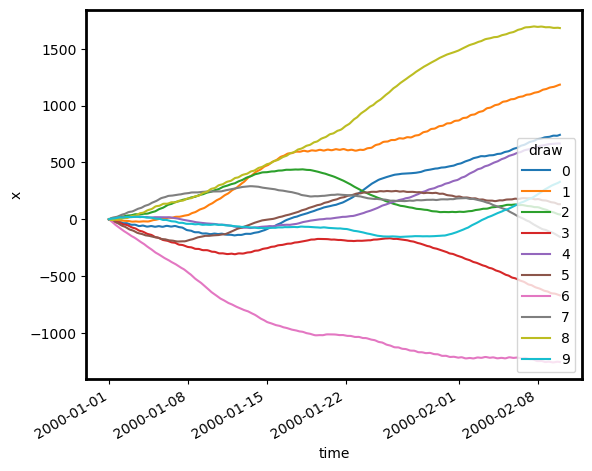

In [14]:
# x in km
_ds = ds.isel(time=slice(0, 2 * 24 * 20))
(_ds["x"] / 1e3).plot.line(x="time");

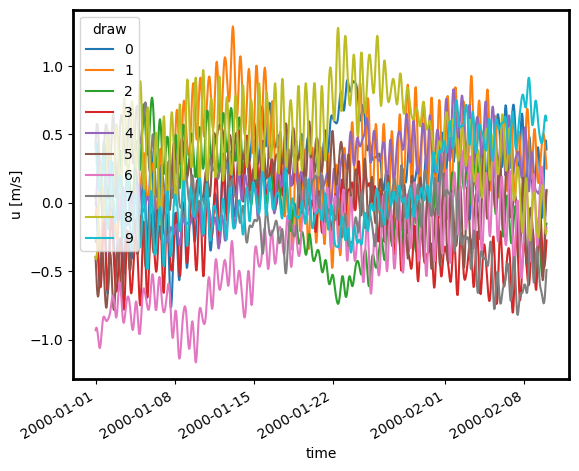

In [15]:
_ds["u"].plot.line(x="time");

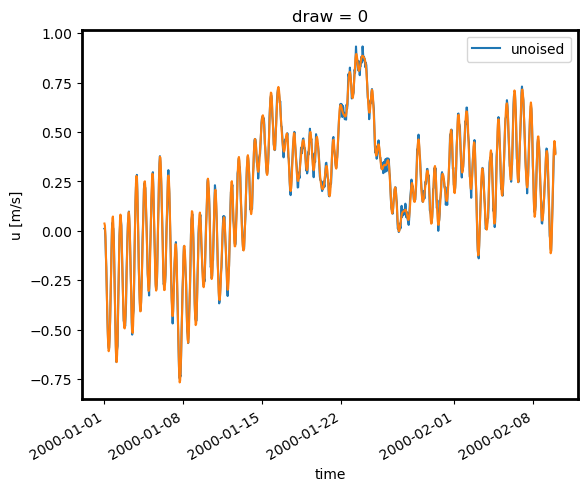

In [18]:
_ds["u_with_noise"].isel(draw=0).plot.line(x="time", label="unoised")
_ds["u"].isel(draw=0).plot.line(x="time")
plt.legend()

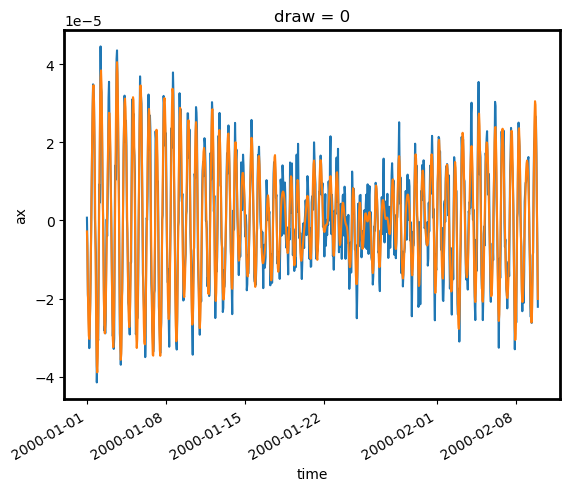

In [14]:
_ds["ax_with_noise"].isel(draw=0).plot.line(x="time")
_ds["ax"].isel(draw=0).plot.line(x="time");

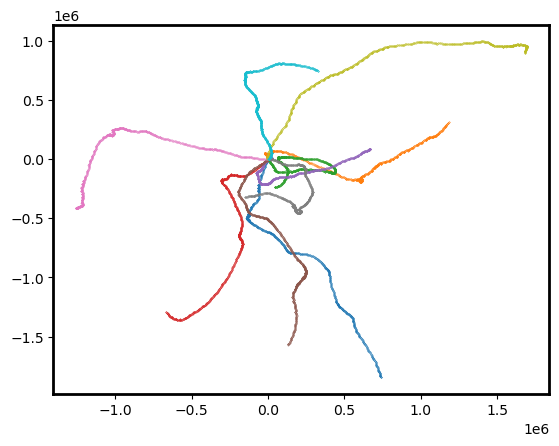

In [15]:
fig, ax = plt.subplots(1, 1)

for d in ds.draw:
    _dsd = _ds.sel(draw=d)
    ax.scatter(_dsd.x, _dsd.y, s=0.05)

In [19]:
# compute autocorrelations
# xx = sigp.correlate(ds.x, ds.x).rename("xx").persist()
# uu = sigp.correlate(ds.u, ds.u).rename("uu").persist()
# aa = sigp.correlate(ds.a, ds.a).rename("aa").persist()
# dsc = xr.merge([xx, uu, aa])

# compute spectra
Ex, omega = sigp.spectrum_welch(ds.x, T=100)
Ex = Ex.sortby("freq_time")
Euv, omega = sigp.spectrum_welch(ds.u + 1j * ds.v, T=100, real=False)
Euv_true = Euv.sortby("freq_time")

Euv, omega = sigp.spectrum_welch(
    ds.u_with_noise + 1j * ds.v_with_noise, T=100, real=False
)
Euv_with_noise = Euv.sortby("freq_time")

# Ea, omega = sigp.spectrum_welch(ds.a, T=100)

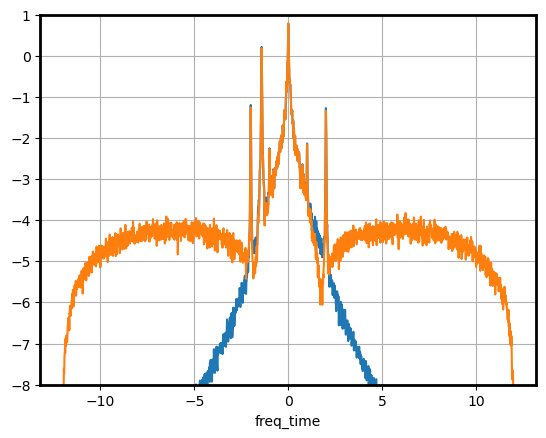

In [20]:
fig, ax = plt.subplots(1, 1)
np.log10(abs(Euv_true).mean("draw")).plot(ax=ax)
np.log10(abs(Euv_with_noise).mean("draw")).plot(ax=ax)
# ax.set_xlim(-6,6)

ax.set_ylim(-8, 1)
ax.grid()

### generate temporal gaps 

frequency of gaps and length of gaps should be representative

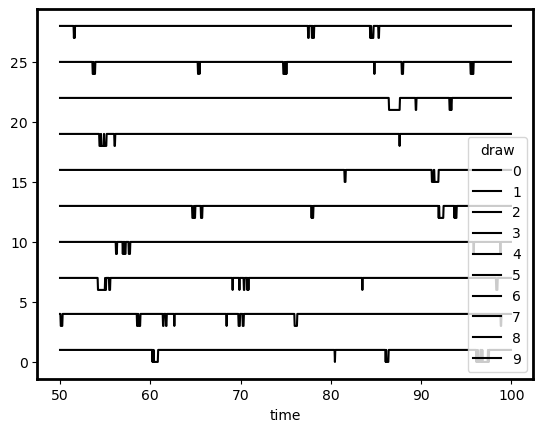

In [21]:
noise = ts.exp_autocorr(t, 1, 1, draws=N, seed=20)
noise1 = noise * 0 + 1

threshold = 2.0

n = noise1.where(noise < threshold, other=0)
# n_bad = noise1.where(noise>=threshold)

(n.isel(time=slice(24 * 50, 24 * 100)) + n.draw * 3).plot.line(x="time", color="k");
# (n_bad.isel(time=slice(24*100, 24*150)) +n.draw*3).plot.line(x='time', color="orange");

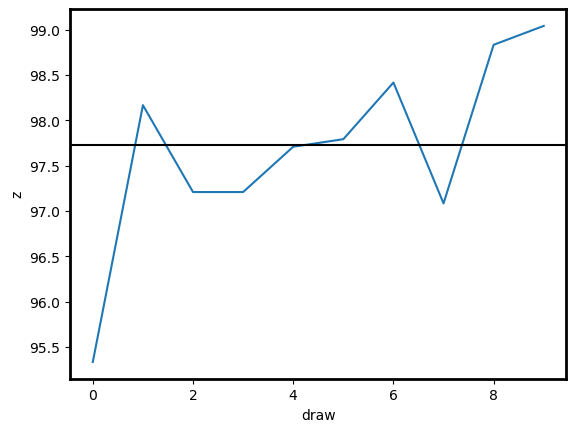

In [22]:
from scipy.stats import norm

fig, ax = plt.subplots(1, 1)
((n.mean("time")) * 1e2).plot()
ax.axhline(norm.cdf(threshold) * 1e2, color="k")

In [23]:
ds["gaps"] = (n.dims, n.data)

In [24]:
# apply masking
for v in ["x", "y"]:
    ds[v] = ds[v].where(ds.gaps == 1)

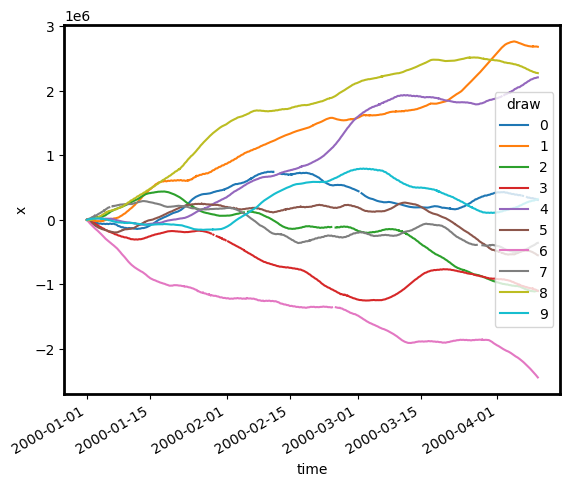

In [25]:
ds["x"].plot.line(x="time");

### randomly distribute sampling times

This requires to re-interpolate signals 

In [26]:
offset = ts.uniform(t, low=-dt / 2, high=dt / 2) * pd.Timedelta("1D")
ds["time_off"] = (ds.time.dims, ds.time.data + offset.data)
ds["time_off"] = ds["time_off"].where(ds.time_off > ds.time[0], other=ds.time[0])
ds["time_off"] = ds["time_off"].where(ds.time_off < ds.time[-1], other=ds.time[-1])

In [27]:
ds_off = ds.interp(time=ds.time_off)[["x", "y"]]
ds_off["time_uniform"] = ds_off["time"]
ds_off["time"] = ds.time_off.values
# ds_off = add_position_noise(ds_off, position_noise) # not working, don't know why (time coordinate mismatch?)

! error here, need to keep x_noise interpolation !
ds_off["x_noise"] = (ds.x_noise.dims, ds.x_noise.values)
ds_off["y_noise"] = (ds.y_noise.dims, ds.y_noise.values)
ds_off

zsh:1: command not found: error


<xarray.Dataset>
Dimensions:       (time: 2400, draw: 10)
Coordinates:
  * draw          (draw) int64 0 1 2 3 4 5 6 7 8 9
  * time          (time) datetime64[ns] 2000-01-01T00:25:43.604357005 ... 200...
Data variables:
    x             (time, draw) float64 dask.array<chunksize=(2400, 10), meta=np.ndarray>
    y             (time, draw) float64 dask.array<chunksize=(2400, 10), meta=np.ndarray>
    time_uniform  (time) datetime64[ns] 2000-01-01 ... 2000-04-09T23:00:00
    x_noise       (time, draw) float64 12.57 -13.21 64.04 ... -43.12 35.08 24.66
    y_noise       (time, draw) float64 34.56 82.16 33.04 ... -25.76 -70.67 144.8

---

## smooth data and interpolate one time series

Diagnostics: spectra on speed and acceleration

In [26]:
# select one timeseries
df = (
    ds_off.compute()
    .sel(draw=2)
    .dropna("time", subset=["x", "y"])  # pandas looses NaNs
    .to_pandas()
    .reset_index()
    .set_index("time")
)

# add velocity/acceleration
# utile ?
df = pyn.geo.compute_velocities(
    df, "x", "y", "index", ("u", "v", "uv"), True, True, None
)
df = pyn.geo.compute_accelerations(
    df,
    ("xy", "x", "y"),
    ("ax", "ay", "axy"),
    True,
    "index",
    False,
    True,
    False,
)

# target regular timeline
t_target = ds["time"].dt.round("1s")

In [27]:
sargs = (t_target, position_noise, 1e-5, 3600)
skwargs = dict(time_chunk=20, geo=False)

# on non-noisy data
dfi = pyn.drifters.resample_smooth(df, *sargs, **skwargs)

# on noisy data
_df = df.copy()
_df["x"] = _df["x"] + _df["x_noise"]
_df["y"] = _df["y"] + _df["y_noise"]

dfi_noise = pyn.drifters.resample_smooth(_df, *sargs, **skwargs)

Chunking dataframe into 20 days chunks
Chunking dataframe into 20 days chunks


In [28]:
(
    df["u"].loc[df.index < dfi.index[-1]].hvplot(label="u from noisy x")
    * dfi["u"].hvplot(label="u cleaned from clean x")
    * dfi_noise["u"].hvplot(label="u cleaned from noisy x")
)

:Overlay
   .Curve.U_from_noisy_x         :Curve   [time]   (u)
   .Curve.U_cleaned_from_clean_x :Curve   [time]   (u)
   .Curve.U_cleaned_from_noisy_x :Curve   [time]   (u)

There seems to be moderate spikes near gaps ... origin?

In [29]:
(
    df["ax"].loc[df.index < dfi.index[-1]].hvplot(label="ax from noisy x")
    * dfi["ax"].hvplot(label="ax cleaned from clean x")
    * dfi_noise["ax"].hvplot(label="ax cleaned from noisy x")
)

:Overlay
   .Curve.Ax_from_noisy_x         :Curve   [time]   (ax)
   .Curve.Ax_cleaned_from_clean_x :Curve   [time]   (ax)
   .Curve.Ax_cleaned_from_noisy_x :Curve   [time]   (ax)

In [30]:
(
    df["x"].hvplot(line_width=5, label="noisy x")
    * dfi["x"].hvplot(label="clean x")
    * dfi_noise["x"].hvplot(label="noisy x")
)

:Overlay
   .Curve.Noisy_x.I  :Curve   [time]   (x)
   .Curve.Clean_x    :Curve   [time]   (x)
   .Curve.Noisy_x.II :Curve   [time]   (x)

## apply smoothing interpolation over all draws

In [1]:
t_target = ds["time"].dt.round("1s")


def smooth_interpolate(ds):

    # select one timeseries
    df = (
        ds.squeeze()
        .dropna("time", subset=["x", "y"])  # pandas looses NaNs
        .to_pandas()
        .reset_index()
    )

    # build actual timeseries
    df = df.set_index("time")

    # target regular timeline
    # t_target = ds["time"].dt.round("1s")

    sargs = (t_target, position_noise, 1e-6, 3600)
    skwargs = dict(time_chunk=20, geo=False)

    # on non-noisy data
    # dfi = pyn.drifters.resample_smooth(df, *sargs, **skwargs)

    # on noisy data
    _df = df.copy()
    _df["x"] = _df["x"] + _df["x_noise"]
    _df["y"] = _df["y"] + _df["y_noise"]

    dfi = pyn.drifters.resample_smooth(_df, *sargs, **skwargs)

    ds = dfi.to_xarray().drop("draw").expand_dims(draw=ds.draw)

    return ds

NameError: name 'ds' is not defined

In [32]:
_ds = ds_off.chunk(dict(draw=1))

template = dfi.to_xarray().drop("draw").expand_dims(draw=ds.draw).chunk(dict(draw=1))

dsi = xr.map_blocks(smooth_interpolate, _ds, template=template).persist()

Chunking dataframe into 20 days chunks
Chunking dataframe into 20 days chunks
Chunking dataframe into 20 days chunks
Chunking dataframe into 20 days chunks
Chunking dataframe into 20 days chunks
Chunking dataframe into 20 days chunks
Chunking dataframe into 20 days chunks
Chunking dataframe into 20 days chunks
Chunking dataframe into 20 days chunks
Chunking dataframe into 20 days chunks


In [33]:
dsi["ax"].isel(draw=0).hvplot()

:Curve   [time]   (ax)

### inspect spectra

In [2]:
Euv, omega = sigp.spectrum_welch(dsi.u + 1j * dsi.v, T=100, real=False)
Euv_denoised = Euv.sortby("freq_time")

NameError: name 'sigp' is not defined

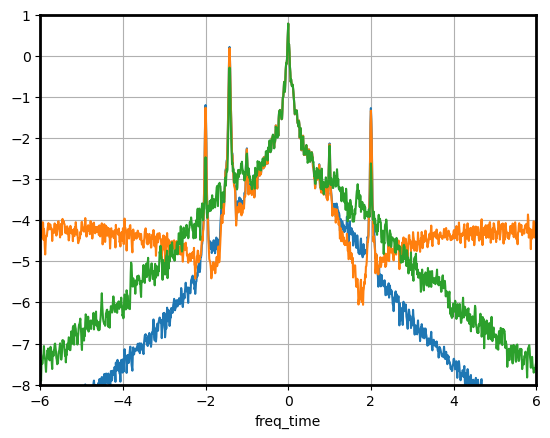

In [35]:
fig, ax = plt.subplots(1, 1)
np.log10(abs(Euv_true).mean("draw")).plot(ax=ax, label="true")
np.log10(abs(Euv_with_noise).mean("draw")).plot(ax=ax, label="noisy")
np.log10(abs(Euv_denoised).mean("draw")).plot(ax=ax, label="denoised")
ax.set_xlim(-6, 6)

ax.set_ylim(-8, 1)
ax.grid()

---
### filter high frequencies 

If one has any doubts about high frequencies

In [36]:
def build_lowpass_filter(cutoff, T):
    """build a low pass filter

    Parameters
    ----------
    cutoff: float
        filter bandwidth in cpd
    T: float
        Filter length
    Returns
    ----------
    F: dict
        Dictionnary containing:
            the filter ("h") and a corresponding time line ("t")
            the filter frequency response ("H") and corresponding frequencies ("f")
            a lambda function to apply the filter
    """
    h = pyn.tseries.generate_filter("low", bandwidth=cutoff, T=T, dt=dt)
    t = np.arange(h.size) * dt - T / 2
    H, f = pyn.tseries.filter_response(h, dt=dt)
    filt = lambda v: np.convolve(v, h, mode="same")
    return dict(h=h, t=t, H=H, f=f, filt=filt, cutoff=cutoff)

In [37]:
f = build_lowpass_filter(2.5, 20)

Text(0.5, 0, '[cpd]')

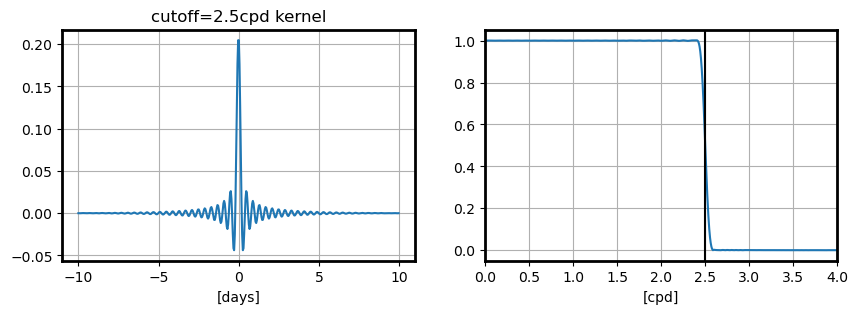

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

ax = axes[0]
ax.plot(f["t"], f["h"])
ax.grid()
ax.set_xlabel("[days]")
ax.set_title("cutoff=" + str(f["cutoff"]) + "cpd kernel")

ax = axes[1]
ax.plot(f["f"], np.abs(f["H"]))
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.axvline(f["cutoff"], color="k")
ax.set_xlim(0, 4)
ax.grid()
ax.set_xlabel("[cpd]")

### apply filter

In [39]:
def filter_xr(x):
    filt = lambda x: np.apply_along_axis(f["filt"], axis=-1, arr=x)
    return xr.apply_ufunc(filt, x, dask="parallelized")


dsi_filtered = xr.merge([filter_xr(dsi[v]) for v in ["x", "y"]])
dsi_filtered = add_velocity_accelerations(
    dsi_filtered, dsi_filtered["x"], dsi_filtered["y"], suffix=""
)

In [40]:
Euv, omega = sigp.spectrum_welch(
    dsi_filtered.u + 1j * dsi_filtered.v, T=100, real=False
)
Euv_denoised_filtered = Euv.sortby("freq_time")

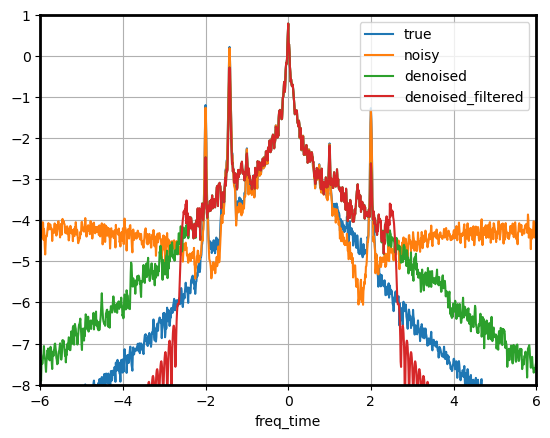

In [41]:
fig, ax = plt.subplots(1, 1)
np.log10(abs(Euv_true).mean("draw")).plot(ax=ax, label="true")
np.log10(abs(Euv_with_noise).mean("draw")).plot(ax=ax, label="noisy")
np.log10(abs(Euv_denoised).mean("draw")).plot(ax=ax, label="denoised")
np.log10(abs(Euv_denoised_filtered).mean("draw")).plot(ax=ax, label="denoised_filtered")
ax.set_xlim(-6, 6)

ax.set_ylim(-8, 1)
ax.grid()
ax.legend()

In [42]:
(
    np.log10(abs(Euv_true).mean("draw")).rename("true").hvplot(label="true")
    * np.log10(abs(Euv_with_noise).mean("draw")).rename("noisy").hvplot(label="noisy")
    * np.log10(abs(Euv_denoised).mean("draw"))
    .rename("denoised")
    .hvplot(label="denoised")
    * np.log10(abs(Euv_denoised_filtered).mean("draw"))
    .rename("denoised_filtered")
    .hvplot(label="denoised filtered")
)

:Overlay
   .Curve.True              :Curve   [freq_time]   (true)
   .Curve.Noisy             :Curve   [freq_time]   (noisy)
   .Curve.Denoised          :Curve   [freq_time]   (denoised)
   .Curve.Denoised_filtered :Curve   [freq_time]   (denoised_filtered)